# Calculating and visualizing the climatology from monthly model output
#### Important: This needs to run with the "calc" python environment
- First import numpy and xarray libraries

In [1]:
import numpy as np
import netCDF4
import xarray as xr
import matplotlib.pyplot as plt

- Next, we need to read in the data. Let's pick SST (tos) from GFDL-ESM4
- Since we can't remember the exact filename, we use "ls" command to find the file and save it as a text file

In [2]:
! ls /global/cfs/cdirs/m3920/dataset/cmip6/GFDL-ESM4/tos*_gr_*.nc > gfdltos.txt
! cat gfdltos.txt

/global/cfs/cdirs/m3920/dataset/cmip6/GFDL-ESM4/tos_GFDL-ESM4_Omon_historical_r1i1p1f1_gr_woagrid.nc


- First read in the text file that contains the name of the file
- Use it to drive xarray.open_dataset
- See the graphic interface to explore metadata and attributes

In [3]:
fid=open('gfdltos.txt','r')
fn=fid.read().splitlines()
ds=xr.open_dataset(fn[0])
ds

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lon: 360, lat: 180)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    tos        (time, lat, lon) float32 ...
Attributes: (12/48)
    CDI:                    Climate Data Interface version 2.0.1 (https://mpi...
    source:                 GFDL-ESM4 (2018):\natmos: GFDL-AM4.1 (Cubed-spher...
    institution:            National Oceanic and Atmospheric Administration, ...
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    history:                Mon Nov 22 21:56:12 2021: cdo mergetime bil_woagr...
    ...                     ...
    tracking_id:            hdl:21.14100/bfcce781-465e-46e9-8721-257c8a80355b
    variable_id:            tos
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1
    CDO:                    Climate Data Operators version 2.0.0 (https://mpi...

- Calculate the monthly climatology from 1950 to 2010
- To do so, we first select the correct time period
- Notice that the number of time slice is reduced to 732 (= 12 x 61)


In [4]:
sst_select = ds.tos.sel(time=slice("1950-01-01","2010-12-31"))
np.shape(sst_select)

(732, 180, 360)

- Group the data by month and take time average
- Make sure that there will be 12 time slices as the output
- Use %%time to measure performance

In [5]:
%%time
sst_monclim = sst_select.groupby('time.month').mean(dim='time')
np.shape(sst_monclim)

CPU times: user 7.67 s, sys: 120 ms, total: 7.79 s
Wall time: 7.79 s


(12, 180, 360)

- Similarly, we can calculate seasonal climatology as follows
- One bug is that the time axis became alphabetical, thus needs to be corrected

In [6]:
%%time
sst_seaclim = sst_select.groupby('time.season').mean(dim='time')
sst_seaclim

CPU times: user 443 ms, sys: 355 ms, total: 797 ms
Wall time: 797 ms


<xarray.DataArray 'tos' (season: 4, lat: 180, lon: 360)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7604091, -1.7600998, -1.7597388, ..., -1.7613826,
         -1.761073 , -1.760767 ],
        [-1.7605796, -1.7604513, -1.7603345, ..., -1.7608716,
         -1.7607723, -1.7606815],
        [-1.7586005, -1.7585762, -1.7585545, ..., -1.7586704,
         -1.7586482, -1.7586243]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.7665753, -1.7663232, -1.7660335, ..., -1.7673813,
         -1.7671132, -1.7668624],
        [-1.7669916, -1.7668767, -1.7667767, ..., -1.7672695,
         -1.767174 , -1.7670875],
        [-1.7654198, -1.7653879, -1.7653586, ..., -1.7655092,
         -1.7654831, -1.765452 ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.7254108, -1.7250032, -1.7245227, ..., -1.7267506,
         -1.7263235, -1.7259028],
        [-1.7268205, -1.726605 , -1.7264025, ..., -1.7273473,
         -1.7271675, -1.7270015],
        [-1.7235069, -1.7234502, -1.7234012, ..., -1.7236699,
         -1.7236161, -1.7235616]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [7]:
sst_seaclim=sst_seaclim.reindex(season=['DJF','MAM','JJA','SON'])

- To conclude, let's plot the seasonal SST climatology
- Explore xarray's .plot function

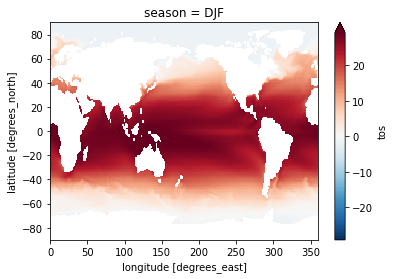

In [8]:
sst_seaclim.sel(season='DJF').plot(robust=True)

- Faceting allows multiple panels from the 3D array

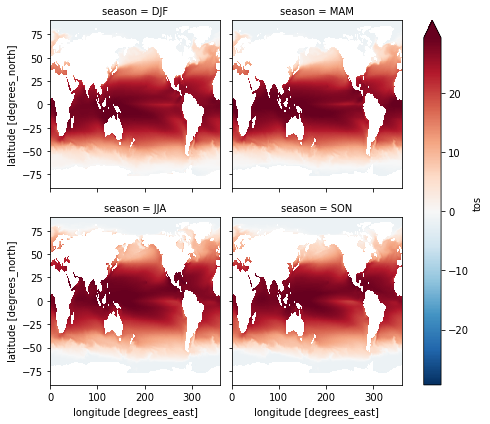

In [9]:
sst_seaclim.plot(col="season",col_wrap=2,robust=True)

- Subtract annual mean to show seasonal changes
- Print a PDF file by uncommenting the last line

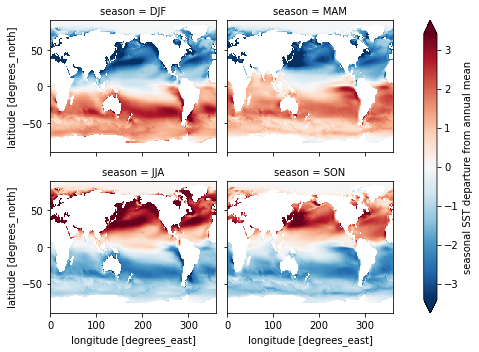

In [10]:
ssta_seaclim=sst_seaclim - sst_seaclim.mean(dim='season')
colorbar_kwargs = {
    "orientation": "vertical",
    "label": "seasonal SST departure from annual mean",
    "pad": 0.07,}
ssta_seaclim.plot(col="season",col_wrap=2,robust=True, figsize=(7,5), cbar_kwargs=colorbar_kwargs)
#plt.savefig('seasonal_sst.pdf',bbox_inches="tight")